# Model

Our model is split into three distinct phases.

1. Infer libraries of abstractions using Dreamcoder program abstraction
2. Refactoring programs using libraries of abstractions
3. Bayesian model of convention formation

In [2]:
# setup

import os
import sys
import urllib, io
os.getcwd()

import numpy as np
import pandas as pd

from collections import Counter
import json
import re
import ast
import pickle

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns

from io import BytesIO
import base64

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [3]:
df_trial = pd.read_csv('../results/csv/df_trial.csv')
df_trial = df_trial[~df_trial.practice]

# 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

df75 = df75[df75['trials']>=9]
includedGames = list(df75.reset_index().gameid)

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

df_trial = df_trial[df_trial.gameid.isin(includedGames)]

df_trial['tower_pair'] = df_trial.leftTarget + df_trial.rightTarget
df_trial.head()

Total dyads achieving 75% Accuracy on 75% of trials: 49


,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,word_count,char_count,n_messages,time_final_block,total_block_duration,total_chat_duration,total_duration,diff,flagged,tower_pair
2,2,5ef784d6ce2f7f58fcd0a3a0,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,0,...,106.0,494.0,7.0,270221.0,95525.0,163658.0,259183.0,11038.0,False,CPi
3,3,5ef7859cce2f7f58fcd0a3d3,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,C,1.0,0,...,88.0,421.0,6.0,191955.0,63542.0,120868.0,184410.0,7545.0,False,LC
4,4,5ef7863ece2f7f58fcd0a405,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,Pi,2.0,0,...,58.0,257.0,3.0,157681.0,67865.0,87195.0,155060.0,2621.0,False,LPi
5,5,5ef786b6ce2f7f58fcd0a439,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,Pi,C,3.0,0,...,42.0,191.0,2.0,114105.0,59293.0,53685.0,112978.0,1127.0,False,PiC
6,6,5ef78732ce2f7f58fcd0a477,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,L,4.0,0,...,29.0,144.0,2.0,119006.0,68445.0,47986.0,116431.0,2575.0,False,CL


## 1. Infering libraries using Dreamcoder



In [3]:
# import model
sys.path.append("./lib_learning/")

from towerPrimitives import primitives
from makeTowerTasks import *
from grammar import *
from fragmentGrammar import *
from gen_seq import *
from utilities import *
import numpy as np
import pickle

In [4]:
ppts = df_trial.gameid.unique()
trials = df_trial.trialNum.unique()

trial_seqs = {} # config is just trial sequence

for i, ppt in enumerate(ppts) :
    trial_seqs[i+1] = []
    for j, trial in enumerate(trials) :
        trial_seqs[i+1].append(df_trial.loc[(df_trial.gameid == ppt) & (df_trial.trialNum == trial),str('tower_pair')].iloc[0])
        # trial_seqs[i][j] = ['tower_pair']

In [5]:
towers = dict(C = SupervisedTower("C", "(h (l 1) v v (r 1) h)"),
                L = SupervisedTower("L", "(h (l 4) h (l 1) v v)"),
                Pi = SupervisedTower("Pi", "(v (r 6) v (l 5) h (r 4) h)"),
                CL = SupervisedTower("CL", "(h (l 1) v v (r 1) h (r 12) h (l 4) h (l 1) v v)"),
                CPi = SupervisedTower("CPi", "(h (l 1) v v (r 1) h (r 6) v (r 6) v (l 5) h (r 4) h)"),
                LPi = SupervisedTower("LPi", "(h (l 4) h (l 1) v v (r 9) v (r 6) v (l 5) h (r 4) h)"),
                LC = SupervisedTower("LC", "(h (l 4) h (l 1) v v (r 12) h (l 1) v v (r 1) h)"),
                PiC = SupervisedTower("PiC", "(v (r 6) v (l 5) h (r 4) h (r 7) h (l 1) v v (r 1) h)"),
                PiL = SupervisedTower("PiL", "(v (r 6) v (l 5) h (r 4) h (r 9) h (l 4) h (l 1) v v)"))

In [6]:
primitives
g0 = Grammar.uniform(primitives, continuationType=ttower)
ws = [1.5, 3.2, 3.3, 9.6]
# ws = list(np.arange(0.0, 10, 0.1))
path = './lib_learning/dsls/'


In [7]:
for ppt in range(1, len(ppts)+1):
    dir_path = os.path.join(path, str(ppt))
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    with open(os.path.join(dir_path, 'configs.p'), 'wb') as fp:
        pickle.dump(trial_seqs[ppt], fp, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
#single ppt first
n_ppts = 1

for ppt in range(1, n_ppts+1):

    with open(os.path.join(path, str(ppt), 'configs.p'), "rb") as input_file:
            trial_seq = pickle.load(input_file)

    jobs = [] # jobs is defined for each participants. Contains 12 subsequences (all scenes up to the current trial)
    
    for i in range(len(trial_seq)+1):
        job = []
        for tower_scene in trial_seq[:i+1]:
            job.append((towers[tower_scene].original, None))
        jobs.append(job)

    for i, job in enumerate(jobs):
        print('this job is of length', i+1)
        # each combo is a list of tuples, each containing 
        # (the base dsl, a dummy frontier for each scene program in job, and a weight)
        combo = [(g0, [Frontier.dummy(p, tp=tp) for p, tp in job], w) for w in ws]
        results = list(map(lambda param: FragmentGrammar.induceFromFrontiers(param[0], param[1], param[2]), combo))
        print(results)
        print('saving!')
        with open(os.path.join(path, str(ppt)) +'/{}.p'.format(i+1), 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

this job is of length 1
[[], [], [], []]
saving!
this job is of length 2
[[#(lambda (lambda (2x1 (left 1 (1x2 (1x2 (right $0 $1)))))))], [], [], []]
saving!
this job is of length 3


KeyboardInterrupt: 

In [ ]:
# the issue here is that inducing frontiers for the later trials (larger sets of programs) becomes too expensive.
# haoliang previously got around this with the built-in parallelMap function
# results = parallelMap(CPUs, lambda param: FragmentGrammar.induceFromFrontiers(param[0], param[1], param[2]), combo)



In [14]:
jobs[1]

[((lambda (2x1 (left 1 (1x2 (1x2 (right 1 (2x1 (right 6 (1x2 (right 6 (1x2 (left 5 (2x1 (right 4 (2x1 $0))))))))))))))),
  None),
 ((lambda (2x1 (left 4 (2x1 (left 1 (1x2 (1x2 (right 12 (2x1 (left 1 (1x2 (1x2 (right 1 (2x1 $0)))))))))))))),
  None)]

In [9]:
FragmentGrammar.induceFromFrontiers(combo[0][0], combo[0][1], combo[0][2])

NameError: name 'combo' is not defined

In [10]:
from multiprocessing import Pool, cpu_count

# Helper function for parallelization
def process_ppt(i, jobs):
    print('this job is of length', i+1)
    combo = [(g0, [Frontier.dummy(p, tp=tp) for p, tp in job], w) for w in ws]
    results = list(map(lambda param: FragmentGrammar.induceFromFrontiers(param[0], param[1], param[2]), combo))
    print(results)
    print('saving!')
    with open(os.path.join(path, str(ppt)) +'/{}.p'.format(i+1), 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    return results

# Main function for parallelization
def parallel_ppt(ppt):
    jobs = []
    for i in range(len(trial_seqs[ppt])+1):
        job = []
        for tower_scene in trial_seqs[ppt][:i+1]:
            job.append((towers[tower_scene].original, None))
        jobs.append(job)

    # Use a process pool to parallelize the task
    with Pool(cpu_count()) as p:
        results = p.starmap(process_ppt, [(i, job) for i, job in enumerate(jobs)])

    return results

# Now, parallelize over ppts
with Pool(cpu_count()) as p:
    all_results = p.map(parallel_ppt, range(1, len(ppts)+1))


Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-5:
Traceback (most recent call last):
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
AttributeError: Can't get attribute 'parallel_ppt' on <module '__main__' (built-in)>
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/will/opt/miniconda3/lib/python3.9/multipr

Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'parallel_ppt' on <module '__main__' (built-in)>
Process SpawnPoolWorker-15:
Traceback (most recent call last):
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/will/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/will/opt/minic

this job is of length 1


this is len: 8


# NEXT: try and get this running in parallel (try the script version)

In [53]:
towers[trial_seqs[1][0]]

Task(name=CPi, request=tower -> tower, examples=[]

## 2. Refactor programs using libraries of abstractions

In [25]:
# import model
sys.path.append("./lib_learning/")

from program import *
import utilities
import render
from parsePrograms import *

from towerPrimitives import primitives
from makeTowerTasks import *
from grammar import *
from fragmentGrammar import *
from gen_seq import *
from enumeration import *
import importlib

from refactorPrograms import * 
import refactorPrograms

In [26]:
importlib.reload(refactorPrograms)

<module 'refactorPrograms' from '/Users/will/compositional-abstractions-ms/model/./lib_learning/refactorPrograms.py'>

In [30]:
# load libraries learned in  previous section
# Read in the DSLs learned by dreamcoder

# todo: update with libraries learned above
# data_path = '../data/model/dsls/'
# data_path = './lib_learning/results/revised/'
data_path = './data/dsls_cogsci/'

dsls = {}
trial_seqs = {}

for ppt in range(1,50):
    
    dsls[ppt] = {}
    
    # read participants' trial sequence
    with open(data_path+f"{ppt}/configs.p", "rb") as config_file:
            trial_seqs[ppt] = pickle.load(config_file)
    
    # read inferred DSLs
    for trial in range(1, 13):
        with open(data_path+f"{ppt}/{trial}.p", "rb") as input_file:
            dsls[ppt][trial] = pickle.load(input_file)

def check_values(value, valid_values, parameter_type):
    if value not in valid_values:
        raise ValueError(f'{parameter_type} must be one of the following values: {valid_values}.')
            
def read_library(ppt, trial, w = 3.2, base_dsl_only=True, sort=False):
    '''
    Returns dsl learned by dreamcoder
    '''
    check_values(ppt, range(1, 50), 'ppt')
    check_values(trial, range(1, 13), 'trial')
    check_values(w, ws, 'w')
    
    lib = [parse(str(fragment), base_dsl_only=base_dsl_only) for fragment in dsls[ppt][trial][w_index[w]]]
    
    if sort:
        lib = sorted(lib, key=lambda x: len(x.split()))
    
    return lib

In [31]:
# setup
ws = [1.5, 3.3, 9.6] # values of w we are considering
w_index = {1.5 : 0,
           3.3 : 2,
           9.6: 3} # positional index of w in loaded data
trials = range(1,13)
ppts = range(1,50)

w = 3.3 # stick with 3.3 from here on
w_position = w_index[w]

See `refactorPrograms.py` for implementation. We incrementally swap in the largest chunks available, checking for smaller chunks until no more swaps are possible.

In [32]:
# refactor the programs
refactor_programs(dsls,
                  trial_seqs,
                  w_position = w_position)

Programs saved in ./data/language_output/programs_ppt_[ppt].json


In [33]:
# inspect programs

ppt = 1

ppt_data = pd.read_json('./data/language_output/programs_ppt_{}.json'.format(ppt))
ppt_data

,ppt,trial_num,towers,dsl_lambda,chunks,dsl,min_program,programs_with_length
0,1,1,LPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,{'h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h': 14}
1,1,2,LC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_4 h l_1 v v r_12 h l_1 v v r_1 h,{'h l_4 h l_1 v v r_12 h l_1 v v r_1 h': 13}
2,1,3,CPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,{'h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h': 14}
3,1,4,PiC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[chunk_8b],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",v r_6 v l_5 h r_4 h r_7 chunk_8b h,"{'v r_6 v l_5 h r_4 h r_7 chunk_8b h': 10, 'v ..."
4,1,5,CL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8b, chunk_Pi]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_8b h r_12 h l_4 h l_1 v v,"{'chunk_8b h r_12 h l_4 h l_1 v v': 9, 'h l_1 ..."
5,1,6,PiL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_Pi r_9 chunk_L,"{'chunk_Pi r_9 chunk_L': 3, 'v r_6 v l_5 h r_4..."
6,1,7,LC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_L r_12 chunk_C,"{'chunk_L r_12 chunk_C': 3, 'h l_4 h l_1 v v r..."
7,1,8,CPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_C r_6 chunk_Pi,"{'chunk_C r_6 chunk_Pi': 3, 'chunk_C r_6 v r_6..."
8,1,9,LPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_L r_9 chunk_Pi,"{'chunk_L r_9 chunk_Pi': 3, 'chunk_L r_9 v r_6..."
9,1,10,CL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_Pi, chunk_8, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_C r_12 chunk_L,"{'chunk_C r_12 chunk_L': 3, 'chunk_C r_12 h l_..."


We also compute a range of programs of different lengths, by replacing chunks their base DSL equivalents. This provides us with a range of programs of different lengths that the convention formation can select between. Longer programs are less ambiguous, but more costly to communicate.

In [25]:
# look at the programs + lengths inferred for the final trial for one trial sequence
ppt_data['programs_with_length'][11]

{'chunk_Pi r_9 chunk_L': 3,
 'v r_6 v l_5 h r_4 h r_9 chunk_L': 9,
 'chunk_Pi r_9 h l_4 h l_1 v v': 8,
 'v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v': 14}

In [32]:
def hex_to_rgb_normalized(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(round(int(hex_color[i:i+2], 16) / 255, 2) for i in (0, 2, 4))

In [33]:
block_color = '#000000'
subtower_color = '#175FFF'
tower_color = '#009948'
scene_color = '#E1AD01'

In [ ]:
# Visualize the breakdown of expressions learned in each run of dreamcoder (with different ws).
# move to file

import pickle
from makeTowerTasks import *
from render import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
sns.set()

sys.path.append('..')

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def get_freq(chunk):
    pair = 0
    tower = 0
    frag = 0
    for item in chunk:
        if str(item.body) in lookup.keys():
            item = lookup[str(item.body)]
            for t in item:
                if t.name == 'C': 
                    tower += 1.
                elif t.name == 'L': 
                    tower += 1.
                elif t.name == 'Pi': 
                    tower += 1.
                elif t.name == 'CL': 
                    pair += 1.
                elif t.name == 'CPi': 
                    pair += 1.
                elif t.name == 'LC': 
                    pair += 1.
                elif t.name == 'LPi': 
                    pair += 1.
                elif t.name == 'PiC': 
                    pair += 1.
                elif t.name == 'PiL': 
                    pair += 1.
                elif t.name == '8': 
                    frag += 1.
                elif t.name == '8b': 
                    frag += 1.
                elif t.name == '7': 
                    frag += 1.
                elif t.name == '6': 
                    frag += 1.
                elif t.name == '5': 
                    frag += 1.
                elif t.name == '4': 
                    frag += 1.
                elif t.name == '3': 
                    frag += 1.
                elif t.name == '2': 
                    frag += 1.
                elif t.name == '1': 
                    frag += 1.

    return frag, tower, pair

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_4650/3697378672.py:86: RuntimeWarning: invalid value encountered in divide
  ffrags_low = ffrags_low_sum/low
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_4650/3697378672.py:87: RuntimeWarning: invalid value encountered in divide
  ffrags_med = ffrags_med_sum/med
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_4650/3697378672.py:88: RuntimeWarning: invalid value encountered in divide
  ffrags_high = ffrags_high_sum/high
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_4650/3697378672.py:89: RuntimeWarning: invalid value encountered in divide
  ttowers_low = ttowers_low_sum/low
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_4650/3697378672.py:90: RuntimeWarning: invalid value encountered in divide
  ttowers_med = ttowers_med_sum/med
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_4650/3697378672.py:91: RuntimeWarning: invalid value encountered in divide
  ttowers_high = tt

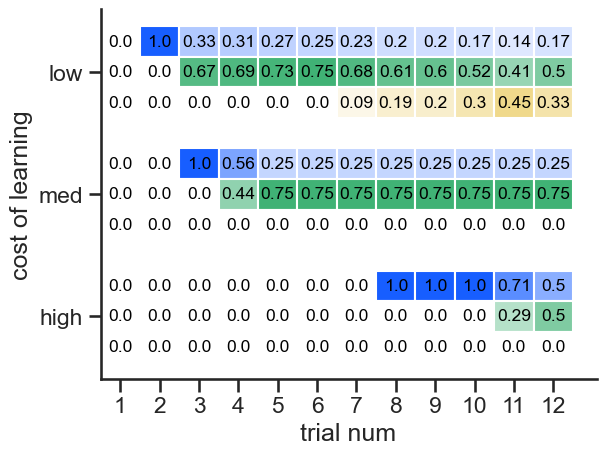

In [139]:
path = './data/dsls_cogsci/'

ffrags_low_mean = []
ffrags_med_mean = []
ffrags_high_mean = []
ttowers_low_mean = []
ttowers_med_mean = []
ttowers_high_mean = []
ppairs_low_mean = []
ppairs_med_mean = []
ppairs_high_mean = []

ppts = [str(x) for x in range(1,50)]

for dirname in ppts:
    ffrags_low = []
    ffrags_med = []
    ffrags_high = []
    ttowers_low = []
    ttowers_med = []
    ttowers_high = []
    ppairs_low = []
    ppairs_med = []
    ppairs_high = []

    data_path = path + dirname + '/'
    # print(data_path)
    for name in range(1, 13):
        with open(data_path+f"{name}.p", "rb") as input_file:
            e = pickle.load(input_file)

        for i, w in enumerate(range(len(e))):
            if i == 0:
                frag, tower, pair = get_freq(e[w])
                ffrags_low.append(frag)
                ttowers_low.append(tower)
                ppairs_low.append(pair)
            elif i == 1:
                frag, tower, pair = get_freq(e[w])
                ffrags_med.append(frag)
                ttowers_med.append(tower)
                ppairs_med.append(pair)
            elif i == 3:
                frag, tower, pair = get_freq(e[w])
                ffrags_high.append(frag)
                ttowers_high.append(tower)
                ppairs_high.append(pair)
    ffrags_low_mean.append(ffrags_low)
    ffrags_med_mean.append(ffrags_med)
    ffrags_high_mean.append(ffrags_high)
    ttowers_low_mean.append(ttowers_low)
    ttowers_med_mean.append(ttowers_med)
    ttowers_high_mean.append(ttowers_high)
    ppairs_low_mean.append(ppairs_low)
    ppairs_med_mean.append(ppairs_med)
    ppairs_high_mean.append(ppairs_high)

ffrags_low_mean = np.array(ffrags_low_mean)
ffrags_med_mean = np.array(ffrags_med_mean)
ffrags_high_mean = np.array(ffrags_high_mean)
ttowers_low_mean = np.array(ttowers_low_mean)
ttowers_med_mean = np.array(ttowers_med_mean)
ttowers_high_mean = np.array(ttowers_high_mean)
ppairs_low_mean = np.array(ppairs_low_mean)
ppairs_med_mean = np.array(ppairs_med_mean)
ppairs_high_mean = np.array(ppairs_high_mean)

ffrags_low_sum = ffrags_low_mean.sum(axis=0)
ffrags_med_sum = ffrags_med_mean.sum(axis=0)
ffrags_high_sum = ffrags_high_mean.sum(axis=0)
ttowers_low_sum = ttowers_low_mean.sum(axis=0)
ttowers_med_sum = ttowers_med_mean.sum(axis=0)
ttowers_high_sum = ttowers_high_mean.sum(axis=0)
ppairs_low_sum = ppairs_low_mean.sum(axis=0)
ppairs_med_sum = ppairs_med_mean.sum(axis=0)
ppairs_high_sum = ppairs_high_mean.sum(axis=0)

low = np.vstack([ffrags_low_sum, ttowers_low_sum, ppairs_low_sum])
med = np.vstack([ffrags_med_sum, ttowers_med_sum, ppairs_med_sum])
high = np.vstack([ffrags_high_sum, ttowers_high_sum, ppairs_high_sum])

low = low.sum(axis=0)
med = med.sum(axis=0)
high = high.sum(axis=0)

ffrags_low = ffrags_low_sum/low
ffrags_med = ffrags_med_sum/med
ffrags_high = ffrags_high_sum/high
ttowers_low = ttowers_low_sum/low
ttowers_med = ttowers_med_sum/med
ttowers_high = ttowers_high_sum/high
ppairs_low = ppairs_low_sum/low
ppairs_med = ppairs_med_sum/med
ppairs_high = ppairs_high_sum/high

where_are_NaNs = np.isnan(ffrags_low)
ffrags_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ffrags_med)
ffrags_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ffrags_high)
ffrags_high[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_low)
ttowers_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_med)
ttowers_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_high)
ttowers_high[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_low)
ppairs_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_med)
ppairs_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_high)
ppairs_high[where_are_NaNs] = 0

df_const = np.array([ffrags_high, ffrags_med, ffrags_low])
df_one = np.array([ttowers_high, ttowers_med, ttowers_low])
df_two = np.array([ppairs_high, ppairs_med, ppairs_low])

xticks = ['high', 'med', 'low']
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")        

    # plot details
    bar_width = 0.25
    two_bar_positions = np.arange(3)
    one_bar_positions = two_bar_positions + bar_width
    const_bar_positions = one_bar_positions + bar_width
    
    rgba_colors_const = np.zeros((3,4))
    rgba_colors_const[:,0:3] = np.array(hex_to_rgb_normalized(subtower_color)*3).reshape((3,3))
    rgba_colors_one = np.zeros((3,4))
    rgba_colors_one[:,0:3] = np.array(hex_to_rgb_normalized(tower_color)*3).reshape((3,3))
    rgba_colors_two = np.zeros((3,4))
    rgba_colors_two[:,0:3] = np.array(hex_to_rgb_normalized(scene_color)*3).reshape((3,3))

#     rgba_colors_const = np.zeros((3,4))
#     rgba_colors_const[:,2] = 1.0
#     rgba_colors_const[:,1] = 0.5
#     rgba_colors_one = np.zeros((3,4))
#     rgba_colors_one[:,0] = 1.0
#     rgba_colors_two = np.zeros((3,4))
#     rgba_colors_two[:,1] = 153/256
#     rgba_colors_two[:,2] = 72/256

    for i in range(12):
        rgba_colors_const[:, 3] = df_const[:,i]
        rgba_colors_one[:, 3] = df_one[:,i]
        rgba_colors_two[:, 3] = df_two[:,i]
        const_labels = [str(x) for x in rgba_colors_const]
        one_labels = [str(x) for x in rgba_colors_one]
        two_labels = [str(x) for x in rgba_colors_two]

        const_bar = plt.barh(const_bar_positions, [1, 1, 1], bar_width,
                                color=rgba_colors_const,
                                left=i*1,
                                tick_label=const_labels)
        for j, p in enumerate(const_bar.patches):
            if rgba_colors_const[j][3]>=0.6:
                clr = 'black'
            else:
                clr = 'black'
            plt.text(p.get_x()+0.5*p.get_width(),p.get_y()+0.5*p.get_height(),str(round(rgba_colors_const[j][3],2)),color=clr,ha='center', va='center', fontsize=12.5)
        one_bar = plt.barh(one_bar_positions, [1, 1, 1], bar_width,
                                color=rgba_colors_one,
                                left=i*1,
                                tick_label=one_labels)
        for j, p in enumerate(one_bar.patches):
            if rgba_colors_one[j][3]>=0.6:
                clr = 'black'
            else:
                clr = 'black'
            plt.text(p.get_x()+0.5*p.get_width(),p.get_y()+0.5*p.get_height(),str(round(rgba_colors_one[j][3],2)),color=clr,ha='center', va='center', fontsize=12.5)
        two_bar = plt.barh(two_bar_positions, [1, 1, 1], bar_width,
                                color=rgba_colors_two,
                                left=i*1,
                                tick_label=two_labels)
        for j, p in enumerate(two_bar.patches):
            if rgba_colors_two[j][3]>=0.6:
                clr = 'black'
            else:
                clr = 'black'
            plt.text(p.get_x()+0.5*p.get_width(),p.get_y()+0.5*p.get_height(),str(round(rgba_colors_two[j][3],2)),color=clr,ha='center', va='center', fontsize=12.5)
    plt.yticks(one_bar_positions, xticks)
    plt.xticks(np.arange(0.5, 12, step=1), [x for x in np.arange(1, 13, step=1)])
    plt.xlabel('trial num')
    plt.ylabel('cost of learning')
#     const_patch = mpatches.Patch(color='red', label='const')
#     one_patch = mpatches.Patch(color='green', label='one')
#     two_patch = mpatches.Patch(color='blue', label='two')
    # plt.legend(handles=[const_patch, two_patch, one_patch], bbox_to_anchor=(.91, .55))
    sns.despine()  
    plt.show()
#     plt.savefig('/Users/cogtoolslab/Desktop/fig.pdf')
#     plt.savefig('~/compositional-abstractions/figures/cogsci21_fragments_all_sequences.pdf')


In [143]:
df_two

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08837209, 0.19008264, 0.2       , 0.3024911 ,
        0.454039  , 0.33333333]])

In [144]:
# pd.DataFrame(df_const).pivot()

df_libs = pd.DataFrame()

arrs = {
    'subtower':df_const,
    'tower':df_one,
    'scene':df_two
}

for level in arrs.keys():
    
    arr = arrs[level]

    # convert numpy array to pandas DataFrame
    df = pd.DataFrame(arr, index=['low', 'med', 'high'])

    # reset index to move row names to a column
    df.reset_index(inplace=True)

    # convert wide-format DataFrame to long-format (tidy) DataFrame
    tidy_df = df.melt(id_vars='index', var_name='trial', value_name='prop')

    tidy_df.trial+=1

    # rename 'index' column to 'row
    tidy_df.rename(columns={'index':'cost'}, inplace=True)
    
    tidy_df.loc[:,'level'] = level

    df_libs = pd.concat([df_libs, tidy_df], axis = 0, ignore_index = True)
df_libs

,cost,trial,prop,level
0,low,1,0.000000,subtower
1,med,1,0.000000,subtower
2,high,1,0.000000,subtower
3,low,2,0.000000,subtower
4,med,2,0.000000,subtower
...,...,...,...,...
103,med,11,0.000000,scene
104,high,11,0.454039,scene
105,low,12,0.000000,scene
106,med,12,0.000000,scene


In [145]:
df_libs[df_libs.cost=='high']

,cost,trial,prop,level
2,high,1,0.000000,subtower
5,high,2,1.000000,subtower
8,high,3,0.333333,subtower
11,high,4,0.310127,subtower
14,high,5,0.273743,subtower
17,high,6,0.250000,subtower
20,high,7,0.227907,subtower
23,high,8,0.202479,subtower
26,high,9,0.200000,subtower
29,high,10,0.174377,subtower


<Figure size 200x800 with 0 Axes>

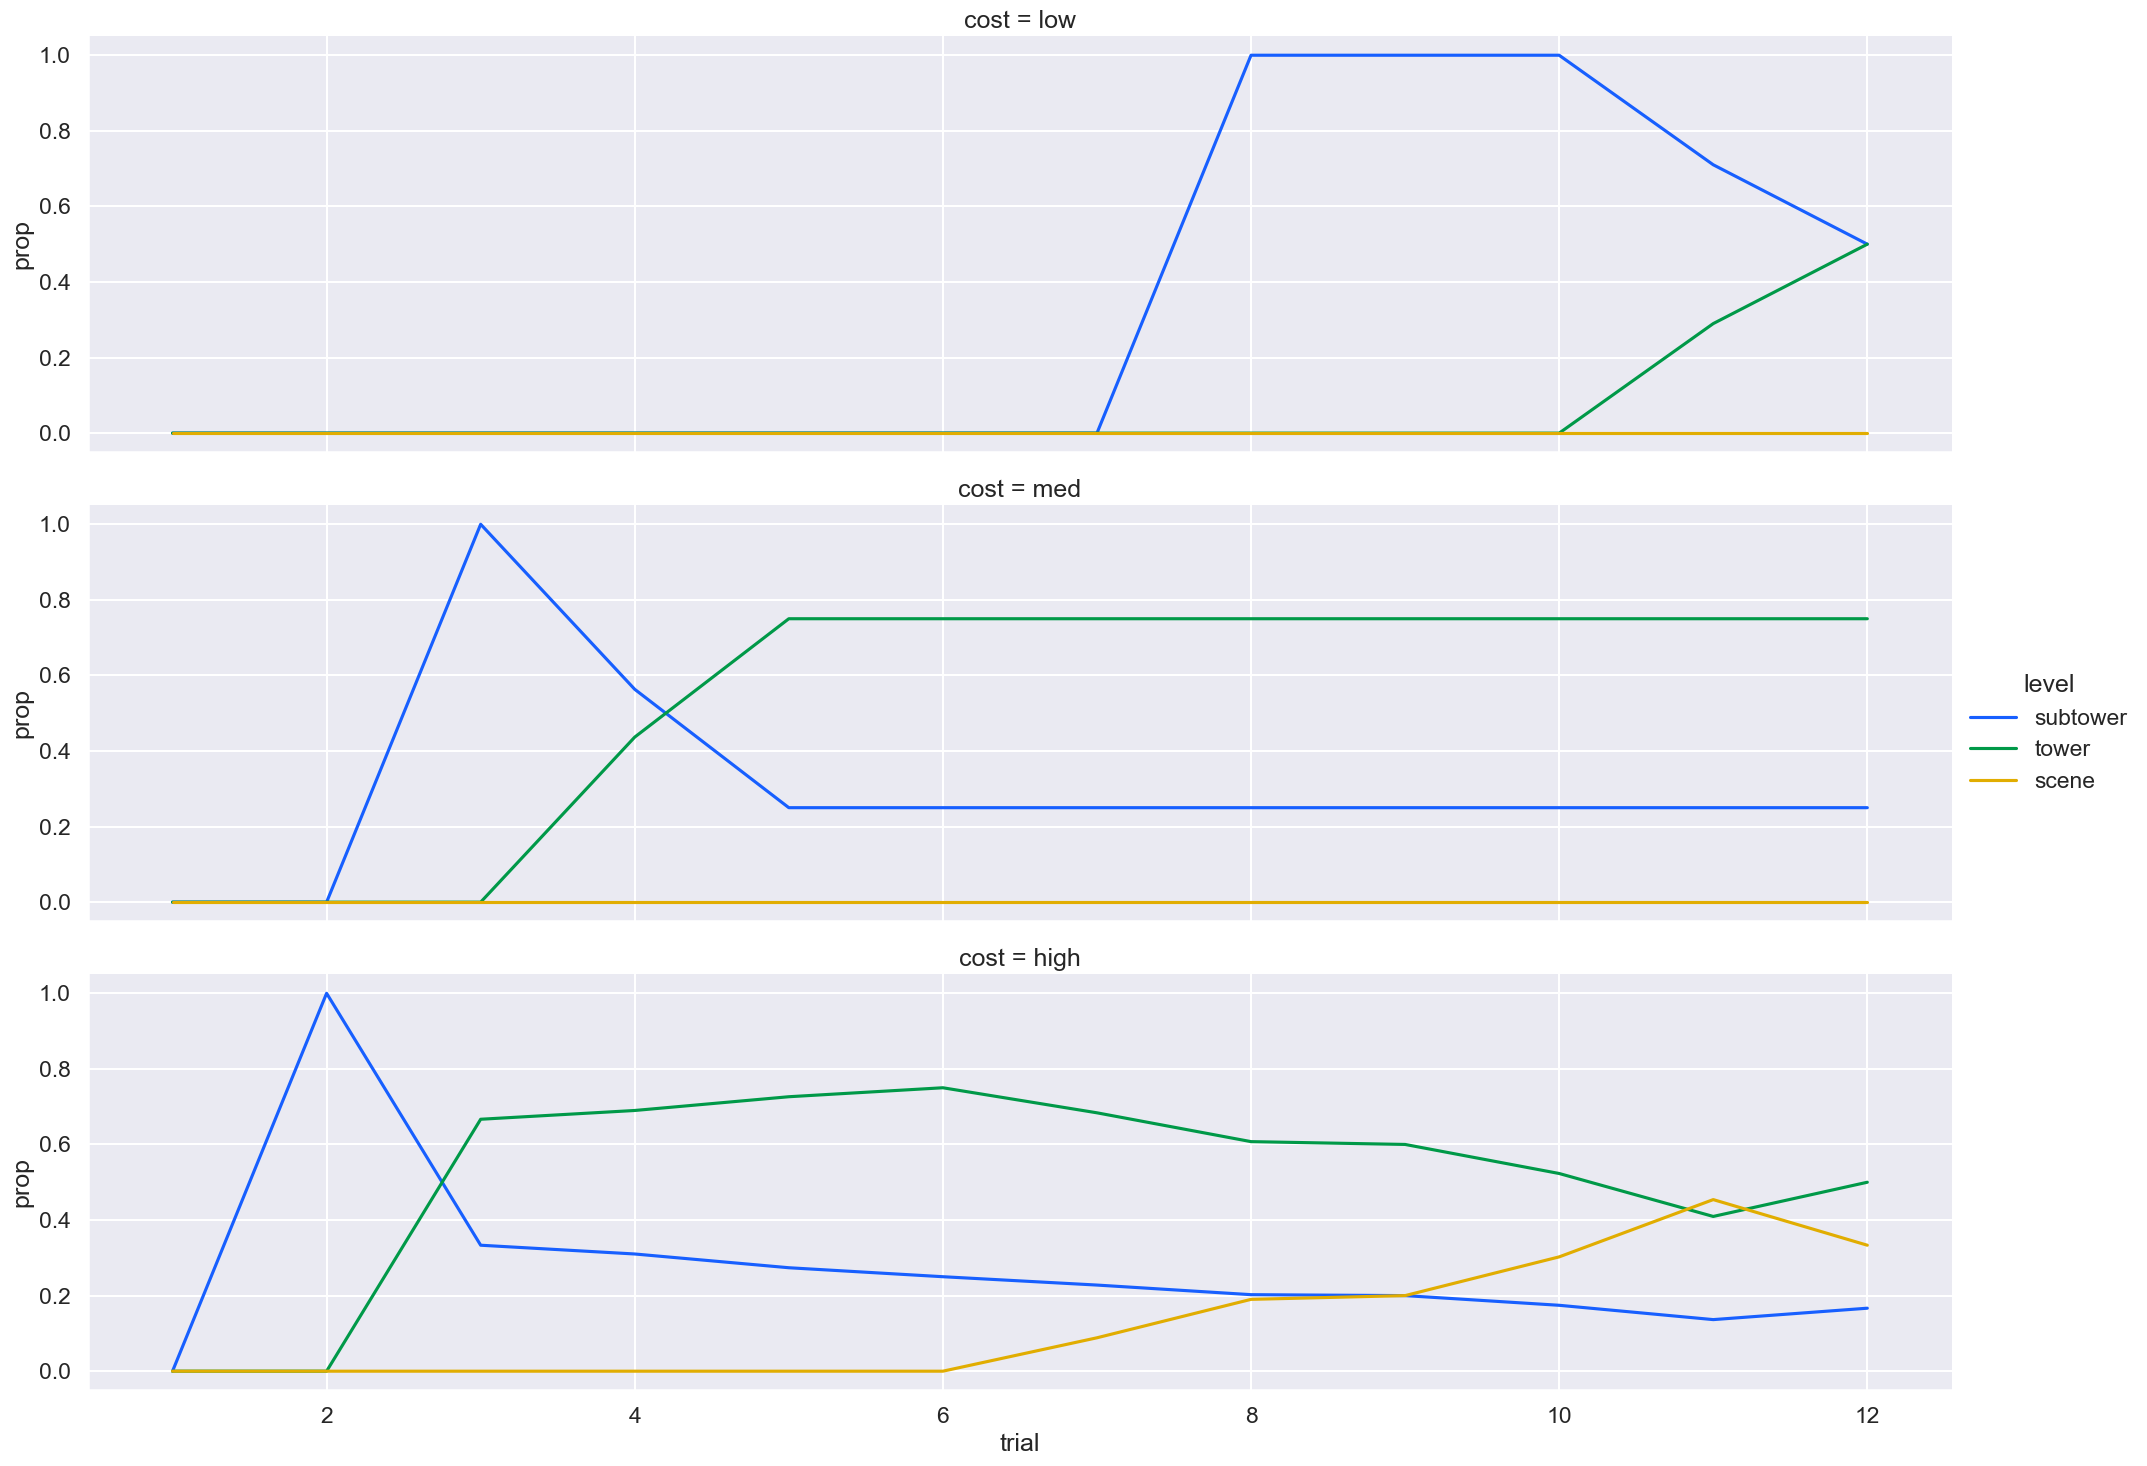

In [146]:
plt.figure(figsize=(2,8))

sns.relplot(df_libs, 
            row='cost', 
            x='trial', 
            y='prop', 
            hue='level', 
            kind='line', 
            hue_order=['subtower','tower','scene'],
            aspect=4,
            palette=[subtower_color, tower_color, scene_color])

<Figure size 200x800 with 0 Axes>

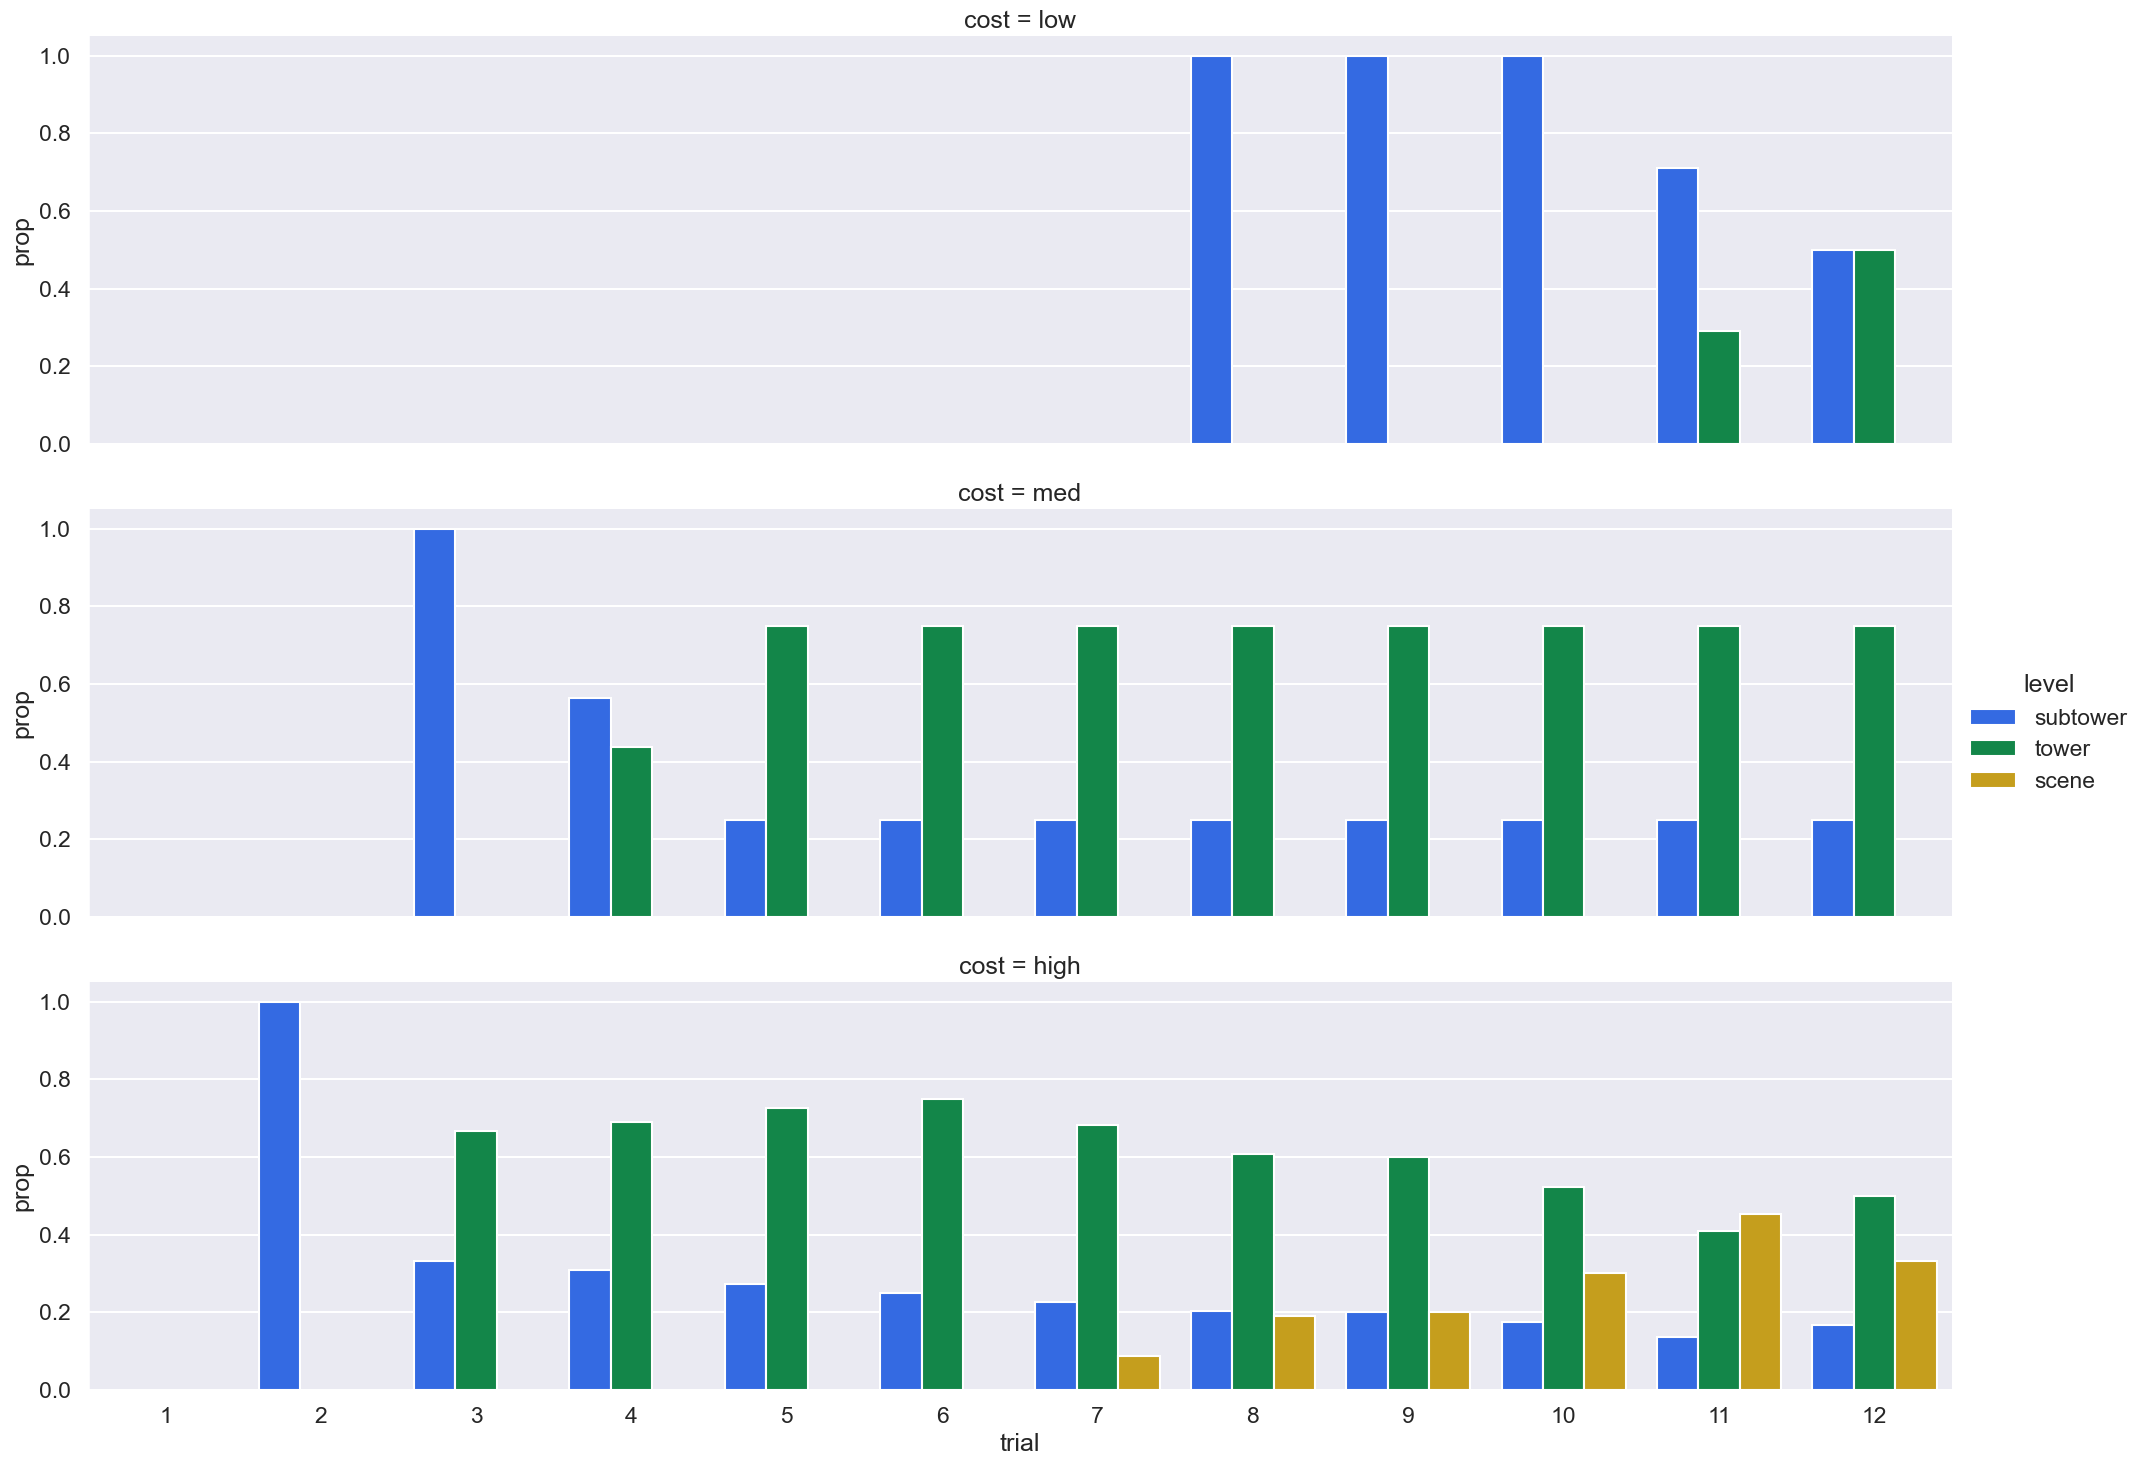

In [147]:
plt.figure(figsize=(2,8))

sns.catplot(df_libs, 
            row='cost', 
            x='trial', 
            y='prop', 
            hue='level', 
            kind='bar', 
            hue_order=['subtower','tower','scene'],
            aspect=4,
            palette=[subtower_color, tower_color, scene_color])

In [148]:
df_libs

,cost,trial,prop,level
0,low,1,0.000000,subtower
1,med,1,0.000000,subtower
2,high,1,0.000000,subtower
3,low,2,0.000000,subtower
4,med,2,0.000000,subtower
...,...,...,...,...
103,med,11,0.000000,scene
104,high,11,0.454039,scene
105,low,12,0.000000,scene
106,med,12,0.000000,scene


In [149]:
df_libs.to_csv('../results/csv/df_lib_props.csv')

In [177]:
# calculate with blocks included

path = './data/dsls_cogsci/'

fblocks_low_mean = []
fblocks_med_mean = []
fblocks_high_mean = []
ffrags_low_mean = []
ffrags_med_mean = []
ffrags_high_mean = []
ttowers_low_mean = []
ttowers_med_mean = []
ttowers_high_mean = []
ppairs_low_mean = []
ppairs_med_mean = []
ppairs_high_mean = []

ppts = [str(x) for x in range(1,50)]

for dirname in ppts:
    fblocks_low = []
    fblocks_med = []
    fblocks_high = []
    ffrags_low = []
    ffrags_med = []
    ffrags_high = []
    ttowers_low = []
    ttowers_med = []
    ttowers_high = []
    ppairs_low = []
    ppairs_med = []
    ppairs_high = []

    data_path = path + dirname + '/'
    # print(data_path)
    for name in range(1, 13):
        with open(data_path+f"{name}.p", "rb") as input_file:
            e = pickle.load(input_file)

        for i, w in enumerate(range(len(e))):
            if i == 0:
                frag, tower, pair = get_freq(e[w])
                block = 2
                fblocks_low.append(block)
                ffrags_low.append(frag)
                ttowers_low.append(tower)
                ppairs_low.append(pair)
            elif i == 1:
                frag, tower, pair = get_freq(e[w])
                block = 2
                fblocks_med.append(block)
                ffrags_med.append(frag)
                ttowers_med.append(tower)
                ppairs_med.append(pair)
            elif i == 3:
                frag, tower, pair = get_freq(e[w])
                block = 2
                fblocks_high.append(block)
                ffrags_high.append(frag)
                ttowers_high.append(tower)
                ppairs_high.append(pair)
                
    fblocks_low_mean.append(fblocks_low)
    fblocks_med_mean.append(fblocks_med)
    fblocks_high_mean.append(fblocks_high)
    ffrags_low_mean.append(ffrags_low)
    ffrags_med_mean.append(ffrags_med)
    ffrags_high_mean.append(ffrags_high)
    ttowers_low_mean.append(ttowers_low)
    ttowers_med_mean.append(ttowers_med)
    ttowers_high_mean.append(ttowers_high)
    ppairs_low_mean.append(ppairs_low)
    ppairs_med_mean.append(ppairs_med)
    ppairs_high_mean.append(ppairs_high)

fblocks_low_mean = np.array(fblocks_low_mean)
fblocks_med_mean = np.array(fblocks_med_mean)
fblocks_high_mean = np.array(fblocks_high_mean)
ffrags_low_mean = np.array(ffrags_low_mean)
ffrags_med_mean = np.array(ffrags_med_mean)
ffrags_high_mean = np.array(ffrags_high_mean)
ttowers_low_mean = np.array(ttowers_low_mean)
ttowers_med_mean = np.array(ttowers_med_mean)
ttowers_high_mean = np.array(ttowers_high_mean)
ppairs_low_mean = np.array(ppairs_low_mean)
ppairs_med_mean = np.array(ppairs_med_mean)
ppairs_high_mean = np.array(ppairs_high_mean)

fblocks_low_sum = fblocks_low_mean.sum(axis=0)
fblocks_med_sum = fblocks_med_mean.sum(axis=0)
fblocks_high_sum = fblocks_high_mean.sum(axis=0)
ffrags_low_sum = ffrags_low_mean.sum(axis=0)
ffrags_med_sum = ffrags_med_mean.sum(axis=0)
ffrags_high_sum = ffrags_high_mean.sum(axis=0)
ttowers_low_sum = ttowers_low_mean.sum(axis=0)
ttowers_med_sum = ttowers_med_mean.sum(axis=0)
ttowers_high_sum = ttowers_high_mean.sum(axis=0)
ppairs_low_sum = ppairs_low_mean.sum(axis=0)
ppairs_med_sum = ppairs_med_mean.sum(axis=0)
ppairs_high_sum = ppairs_high_mean.sum(axis=0)

low = np.vstack([fblocks_low_sum, ffrags_low_sum, ttowers_low_sum, ppairs_low_sum])
med = np.vstack([fblocks_med_sum, ffrags_med_sum, ttowers_med_sum, ppairs_med_sum])
high = np.vstack([fblocks_high_mean, ffrags_high_sum, ttowers_high_sum, ppairs_high_sum])

low = low.sum(axis=0)
med = med.sum(axis=0)
high = high.sum(axis=0)

fblocks_low = fblocks_low_sum/low
fblocks_med = fblocks_med_sum/med
fblocks_high = fblocks_high_sum/high
ffrags_low = ffrags_low_sum/low
ffrags_med = ffrags_med_sum/med
ffrags_high = ffrags_high_sum/high
ttowers_low = ttowers_low_sum/low
ttowers_med = ttowers_med_sum/med
ttowers_high = ttowers_high_sum/high
ppairs_low = ppairs_low_sum/low
ppairs_med = ppairs_med_sum/med
ppairs_high = ppairs_high_sum/high

where_are_NaNs = np.isnan(fblocks_low)
ffrags_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(fblocks_med)
ffrags_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(fblocks_high)
ffrags_high[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ffrags_low)
ffrags_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ffrags_med)
ffrags_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ffrags_high)
ffrags_high[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_low)
ttowers_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_med)
ttowers_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ttowers_high)
ttowers_high[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_low)
ppairs_low[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_med)
ppairs_med[where_are_NaNs] = 0
where_are_NaNs = np.isnan(ppairs_high)
ppairs_high[where_are_NaNs] = 0

df_blocks = np.array([fblocks_high, fblocks_med, fblocks_low])
df_subtowers = np.array([ffrags_high, ffrags_med, ffrags_low])
df_towers = np.array([ttowers_high, ttowers_med, ttowers_low])
df_scenes = np.array([ppairs_high, ppairs_med, ppairs_low])


In [180]:
# pd.DataFrame(df_const).pivot()

df_libs = pd.DataFrame()

arrs = {
    'block':df_blocks,
    'subtower':df_subtowers,
    'tower':df_towers,
    'scene':df_scenes
}

for level in arrs.keys():
    
    arr = arrs[level]

    # convert numpy array to pandas DataFrame
    df = pd.DataFrame(arr, index=['low', 'med', 'high'])

    # reset index to move row names to a column
    df.reset_index(inplace=True)

    # convert wide-format DataFrame to long-format (tidy) DataFrame
    tidy_df = df.melt(id_vars='index', var_name='trial', value_name='prop')

    tidy_df.trial+=1

    # rename 'index' column to 'row
    tidy_df.rename(columns={'index':'cost'}, inplace=True)
    
    tidy_df.loc[:,'level'] = level

    df_libs = pd.concat([df_libs, tidy_df], axis = 0, ignore_index = True)
df_libs

,cost,trial,prop,level
0,low,1,1.000000,block
1,med,1,1.000000,block
2,high,1,1.000000,block
3,low,2,1.000000,block
4,med,2,1.000000,block
...,...,...,...,...
139,med,11,0.000000,scene
140,high,11,0.356674,scene
141,low,12,0.000000,scene
142,med,12,0.000000,scene


In [181]:
df_libs.to_csv('../results/csv/df_lib_props_block.csv')

## 3. Bayesian model of convention formation

Now we have inferred libraries of abstractions, and programs representing each scene that use more or less of these abstractions. Now we want to model how agents coordinate on words for describing a scene.

We provide two implementations of our convention formation model: in webppl and in python.

### Python implementation

In [38]:
# import classes for our model
sys.path.append("../model/convention_formation/python_implementation/")
from distribution import *
from lexicon import *

In [43]:
# data for a single "participant"/ trial sequence
empirical_data = pd.read_json('data/language_output/programs_ppt_1.json')

# Define a set of meaningless placeholder words available to be bound to meanings
lexemes = ['blah', 'blab', 'bloop', 'bleep', 'floop'] 

In [44]:
class FixedAgent() :
    def __init__(self, role, trial) :
        '''
        Args: 
           * role: string giving agent's role in the task ('architect' or 'builder')
           * trial: dictionary of meta-data about the current trial 
        '''

        # initialize beliefs to a uniform prior over possible lexicons, as above
        self.beliefs = LexiconPrior(trial['dsl'], lexemes)

        # set other useful properties
        self.role = role
        self.actions = trial['dsl']
        self.utterances = self.beliefs.sample().utterances
        
    def act(self, observation) :
        '''
        produce an action based on role and current beliefs
        '''
        if self.role == 'architect' :
            # Architect is going to build up a distribution over utterances to say
            utt_dist = self.beliefs.marginalize(lambda l : l.dsl_to_language(observation))
            return utt_dist.sample()

        if self.role == 'builder' :
            # get P(a | utt) by marginalizing over lexicons 
            action_dist = self.beliefs.marginalize(lambda l : l.language_to_dsl(observation))
            return action_dist.sample()

In [45]:
def run_simulation(trial_info) :
    output = SimulationOutput()
    for i, trial in trial_info.iterrows() :
        # Initialize agents using current trial metadata
        architect = FixedAgent('architect', trial)
        builder = FixedAgent('builder', trial)

        # if there are multiple program representations, randomly 
        # select which one to comunicate (we will return to this)
        target_program = choice(list(trial['programs_with_length'].keys()))

        # loop through steps of target program one at a time
        # produce an utterance from architect and response from builder
        for step in target_program.split(' ') :
            utt = architect.act(step)
            response = builder.act(utt)
            output.save(step, utt, response) 

        # flush output buffer and prepare for next trial
        output.flush(trial, target_program)
    return output.get_df()

In [52]:
# we can call the run_simulation function above to simulate the utterances and actions that would be generated 
# in a 12-trial interaction between the Architect and Builder. Note that if you run it multiple times, you'll get 
# different simulated outcomes each time. 
run_0 = run_simulation(empirical_data)
display(run_0)

,trial,utterance,response,intention,target_program,dsl,target_length,acc
0,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
1,1.0,move to the left by 4,l_4,l_4,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
2,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
3,1.0,move to the left by 1,l_1,l_1,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
4,1.0,place a vertical block.,v,v,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
...,...,...,...,...,...,...,...,...
9,12.0,move to the left by 4,l_4,l_4,v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
10,12.0,place a horizontal block.,h,h,v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
11,12.0,move to the left by 1,l_1,l_1,v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
12,12.0,place a vertical block.,v,v,v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0


In [53]:
print('target program: \n', run_0.query('trial==1').loc[0,'target_program'])
run_0.query('trial==1')[['utterance','intention','response','acc']]

target program: 
 h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h


,utterance,intention,response,acc
0,place a horizontal block.,h,h,1.0
1,move to the left by 4,l_4,l_4,1.0
2,place a horizontal block.,h,h,1.0
3,move to the left by 1,l_1,l_1,1.0
4,place a vertical block.,v,v,1.0
5,place a vertical block.,v,v,1.0
6,move to the right by 9,r_9,r_9,1.0
7,place a vertical block.,v,v,1.0
8,move to the right by 6,r_6,r_6,1.0
9,place a vertical block.,v,v,1.0


In [55]:
# let's inspect the final trial
print('target program: \n', run_0.query('trial==12').loc[0,'target_program'])
run_0.query('trial==12')[['utterance','intention','response','acc']]

target program: 
 v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v


,utterance,intention,response,acc
0,place a vertical block.,v,v,1.0
1,move to the right by 6,r_6,r_6,1.0
2,place a vertical block.,v,v,1.0
3,move to the left by 5,l_5,l_5,1.0
4,place a horizontal block.,h,h,1.0
5,move to the right by 4,r_4,r_4,1.0
6,place a horizontal block.,h,h,1.0
7,move to the right by 9,r_9,r_9,1.0
8,place a horizontal block.,h,h,1.0
9,move to the left by 4,l_4,l_4,1.0


#### Simulating learning

In [57]:
class LearningAgent(FixedAgent) :
    def __init__(self, role, curr_trial, previous_trials) :
        super().__init__(role, curr_trial)
        combined_primitives = (set().union(curr_trial['dsl'], *previous_trials['dsl']) 
                                if not previous_trials.empty else self.actions)

        # Initialize beliefs to uniform prior and then compute 
        self.prior = LexiconPrior(combined_primitives, lexemes)
        self.update_beliefs(previous_trials)

    def B0(self, utterance, lexicon) :
        '''
        simple builder agent that has equal probability
        of building anything that's literally consistent with the utterance
        '''
        builder_dist = EmptyDistribution()
        for action in self.actions :
            builder_dist.update({action : 1 if action == lexicon.language_to_dsl(utterance) else 0.01})
        builder_dist.renormalize()
        return builder_dist
        
    def A0(self, intention, lexicon) :
        '''
        simple architect agent that has equal probability
        of saying anything that's literally consistent with the intention
        '''
        architect_dist = EmptyDistribution()
        for utt in self.utterances :
            architect_dist.update({utt : 1 if utt == lexicon.dsl_to_language(intention) else 0.01})
        architect_dist.renormalize()
        return architect_dist

    def update_beliefs(self, previous_trial_df) :
        '''
        run bayes rule given observations in previous trials
        note that we run the calculation in log space because it's more numerically stable
        '''
        posterior = EmptyDistribution()
        posterior.to_logspace()

        # we're manually doing the calculation in Bayes Rule
        # P(l | obs) \propto P(l) * \prod_{o \in obs} P(o | l)
        # ==> log P(l|obs) \propto log P(l) + \sum_{o \in obs} log P(o | l)
        for lexicon in self.prior.support() :
            # calculate the likelihood of the previous data under each lexicon, 
            likelihood_term = 0
            for i, step in previous_trial_df.iterrows() :
                if self.role == 'architect' :
                    likelihood_term += np.log(self.B0(step.utterance, lexicon).score(step.response))
                elif self.role == 'builder' :
                    likelihood_term += np.log(self.A0(step.intention, lexicon).score(step.utterance))
            
            # weight by the prior probability of that lexicon
            prior_term = np.log(self.prior.score(lexicon))
            posterior.update({lexicon : prior_term + likelihood_term})

        # Renormalize (this is the \propto part of Bayes Rule, the denominator)
        posterior.renormalize()
        posterior.from_logspace()
        self.beliefs = posterior

In [58]:
def run_learning_simulation(trial_info, verbose = False) :
    output = SimulationOutput()
    for i, current_trial in trial_info.iterrows() :
        clear_output(wait=True)
        print(f'trial {i}/12')
        
        # construct agents with updated beliefs up to this point
        previous_trials = output.get_df()
        architect = LearningAgent('architect', current_trial, previous_trials)
        builder = LearningAgent('builder', current_trial, previous_trials) 

        # random program selected from the options
        target_program = choice(list(current_trial['programs_with_length'].keys()))

        # loop through steps of target program one at a time
        for step in target_program.split(' ') :
            utt = architect.act(step)
            response = builder.act(utt)
            output.save(step, utt, response) 
        
        output.flush(current_trial, target_program)
    return output.get_df()

In [59]:
learning_run_0 = run_learning_simulation(empirical_data, verbose = True)
learning_run_0

trial 11/12


,trial,utterance,response,intention,target_program,dsl,target_length,acc
0,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
1,1.0,move to the left by 4,l_4,l_4,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
2,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
3,1.0,move to the left by 1,l_1,l_1,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
4,1.0,place a vertical block.,v,v,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
...,...,...,...,...,...,...,...,...
7,11.0,move to the right by 7,r_7,r_7,v r_6 v l_5 h r_4 h r_7 chunk_C,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",9.0,1.0
8,11.0,place a bleep.,chunk_8,chunk_C,v r_6 v l_5 h r_4 h r_7 chunk_C,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",9.0,0.0
0,12.0,place a blah.,chunk_C,chunk_Pi,chunk_Pi r_9 chunk_L,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",3.0,0.0
1,12.0,move to the right by 9,r_9,r_9,chunk_Pi r_9 chunk_L,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",3.0,1.0


#### Choosing programs

In [60]:
from scipy.special import softmax

class StrategicArchitect(LearningAgent) :
    def __init__(self, curr_trial, previous_trials) :
        super().__init__('architect', curr_trial, previous_trials) 
        self.alpha = 2
        self.beta = .3

    def expected_inf(self, utterance, intention) :
        '''
        computes the expected utility of transmitting the given intention with utterance
        accounting for uncertainty of whether utterance will work
        '''
            # calculate expected inf(u) = \sum_a*\in A* \sum_L P(L) * ln P_B(a* | u, L) 
        return sum([
            self.beliefs.score(l) * np.log(self.B0(utterance, l).score(intention))
            for l in self.beliefs.support()
        ])
        
    def speak(self, possible_programs) :
        '''
        produce an action based on role and current beliefs
        '''
        # Architect is going to build up a distribution over utterances to say
        # Architect selects which program representation to comunicate proportional to informativity and length
        p_utils = []
        for target_program in possible_programs: 
            step_utils = []
            for step in target_program.split(' ') :
                utt_utils = np.array([self.expected_inf(utt, step) for utt in self.utterances])
                step_utils.append(sum(utt_utils * softmax(self.alpha * utt_utils)))
            p_utils.append(   
                (1 - self.beta) * np.mean(step_utils) 
              - (    self.beta) * len(target_program.split(' '))
            )
            print(p_utils)
        # sample a program
        chosen_p = choice(a = possible_programs, p = softmax(self.alpha * np.array(p_utils)))
        # sample utterances for that program
        return chosen_p, [self.act(step) for step in chosen_p.split(' ')]

def run_strategic_simulation(empirical_data) :
    output = SimulationOutput()
    for i, current_trial in empirical_data.iterrows() :
        previous_trials = output.get_df()
        architect = StrategicArchitect(current_trial, previous_trials)
        builder = LearningAgent('builder', current_trial, previous_trials)

        # Jointly pick a program to communicate, and what to say
        possible_programs = list(current_trial['programs_with_length'].keys())
        chosen_program, utt_seq = architect.speak(possible_programs)
        print(f'trial: {i}, chosen program: {chosen_program}')

        # loop through steps of target program one at a time
        for intention, utt in zip(chosen_program.split(' '), utt_seq) :
            response = builder.act(utt)
            output.save(intention, utt, response)
            
        output.flush(current_trial, chosen_program)
    return output.get_df()

print(run_strategic_simulation(empirical_data))

[-4.375992165077049]
trial: 0, chosen program: h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h
[-4.075992165077048]
trial: 1, chosen program: h l_4 h l_1 v v r_12 h l_1 v v r_1 h
[-4.375992165077049]
trial: 2, chosen program: h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h
[-3.181802985509923]
[-3.181802985509923, -4.381802985509923]
trial: 3, chosen program: v r_6 v l_5 h r_4 h r_7 chunk_8b h
[-2.8912079586132675]
[-2.8912079586132675, -4.0875710160956835]
trial: 4, chosen program: h l_1 v v r_1 h r_12 h l_4 h l_1 v v
[-2.8975790919034914]
[-2.8975790919034914, -3.1994409247394207]
[-2.8975790919034914, -3.1994409247394207, -2.936894378918522]
[-2.8975790919034914, -3.1994409247394207, -2.936894378918522, -4.399813291306607]
trial: 5, chosen program: v r_6 v l_5 h r_4 h r_9 chunk_L
[-2.7823767671564292]
[-2.7823767671564292, -2.9152875630396595]
[-2.7823767671564292, -2.9152875630396595, -2.9152875630396595]
[-2.7823767671564292, -2.9152875630396595, -2.9152875630396595, -4.099805439012713]
trial: 6,

### webppl implementation

1. Move to the `webppl_implementation` directory.

2. Run `webppl_implementation/input/generate_grid.py` to generate the input files for the webppl model.

3. Run `run_model.sh` to run the webppl model on the generated input files, using the following script:

`parallel --bar --colsep ',' "sh ./run_model.sh {1} {2} {3} {4}" :::: webppl_input/grid_49ppts.csv
webppl coordinate_DSL_pragmatic_speaker.wppl --require webppl-json --require webppl-csv -- --numIterations=2 --chainNum=$1 --alpha=$2 --beta=$3 --participantNumber=$4`

In [50]:
import glob

In [21]:
model_output_dir = os.path.abspath('./convention_formation/webppl_implementation/output/')
df_model = pd.read_csv(
    model_output_dir + '/trajectories.csv', index_col=None
).sort_values(
    ['ppt','iteration','chainNum','alpha','beta','trialNum']
)

# all_files = glob.glob(model_output_dir + "/*.csv")
# li = []
# for filename in all_files:
#     li.append(df)

# df_model = pd.concat(li, axis=0, ignore_index=True)

In [22]:
df_model.head()

,chainNum,ppt,modelType,iteration,alpha,beta,epsilon,trialNum,accuracy,descriptionLength,intendedSequence,speakerUtterance,listenerResponse
0,0,1,full,0,5,0.1,0.01,0,False,14,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,h l_4 l_7 l_1 v v r_9 v r_6 v l_5 h r_4 h
1,0,1,full,0,5,0.1,0.01,1,True,13,h l_4 h l_1 v v r_12 h l_1 v v r_1 h,place a horizontal block.~~~move to the left b...,h l_4 h l_1 v v r_12 h l_1 v v r_1 h
2,0,1,full,0,5,0.1,0.01,2,True,14,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h
3,0,1,full,0,5,0.1,0.01,3,True,14,v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h,place a vertical block.~~~move to the right by...,v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h
4,0,1,full,0,5,0.1,0.01,4,True,13,h l_1 v v r_1 h r_12 h l_4 h l_1 v v,place a horizontal block.~~~move to the left b...,h l_1 v v r_1 h r_12 h l_4 h l_1 v v


In [23]:
def get_intended_refs(intendedSequenceList):
    return[exp for exp in intendedSequenceList if ((not exp.startswith('r_')) & ( not exp.startswith('l_')))]

In [24]:
# preprocessing

df_model['intendedSequenceList'] = df_model['intendedSequence'].apply(lambda string: string.split(' '))
df_model['listenerResponseList'] = df_model['listenerResponse'].apply(lambda string: string.split(' '))
df_model['speakerUtteranceList'] = df_model['speakerUtterance'].apply(lambda string: string.split('~~~'))

df_model['speakerUtteranceWords'] = df_model['speakerUtterance'].apply(lambda string: string.split('~~~'))
df_model['intended_refs'] = df_model['intendedSequenceList'].apply(get_intended_refs)

#checks
assert np.all(df_model['intendedSequenceList'].apply(len) == df_model['descriptionLength'])
assert np.all(df_model['speakerUtteranceList'].apply(len) == df_model['descriptionLength'])

df_model['repetition'] = np.floor((df_model['trialNum']/3))+1

In [25]:
intended_abstraction_levels = {
    'v': 'block',
    'h': 'block',
    'chunk_L': 'tower',
    'chunk_Pi': 'tower',
    'chunk_C': 'tower',
    'chunk_8': 'subtower',
    'chunk_8b': 'subtower',
    'chunk_9': 'subtower'
}

def abstraction_level(intended_ref):
    assert intended_ref in intended_abstraction_levels.keys()
    if intended_ref in intended_abstraction_levels.keys():
        return intended_abstraction_levels[intended_ref]
    else:
        print(intended_ref)
        return 'UNKNOWN'

In [26]:
df_model['intended_abstraction_level'] = \
        df_model['intended_refs'].apply(lambda intended_refs: [abstraction_level(ref) for ref in intended_refs])

In [27]:
df_model['intended_blocks'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['block'])
df_model['intended_subtowers'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['subtower'])
df_model['intended_towers'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['tower'])

In [28]:
def score_action_response(intended, executed):
    if intended==executed:
        if (intended.startswith('l_') or intended.startswith('r_')):
            return 0
        if (intended=='h') or (intended=='v'):
            return 1
        if (intended=='chunk_Pi') or (intended=='chunk_L') or (intended=='chunk_C'):
            return 4
        if (intended=='chunk_8') or (intended=='chunk_8b'):
            return 3
        if (intended=='chunk_9'):
            return 2
        else:
            print(intended)
    else:
        return 0

In [34]:
block_palette = sns.light_palette(block_color, reverse=False, as_cmap=True)
subtower_palette = sns.light_palette(subtower_color, reverse=False, as_cmap=True)
tower_palette = sns.light_palette(tower_color, reverse=False, as_cmap=True)

In [35]:
df_model

,chainNum,ppt,modelType,iteration,alpha,beta,epsilon,trialNum,accuracy,descriptionLength,...,intendedSequenceList,listenerResponseList,speakerUtteranceList,speakerUtteranceWords,intended_refs,repetition,intended_abstraction_level,intended_blocks,intended_subtowers,intended_towers
0,0,1,full,0,5,0.1,0.01,0,False,14,...,"[h, l_4, h, l_1, v, v, r_9, v, r_6, v, l_5, h,...","[h, l_4, l_7, l_1, v, v, r_9, v, r_6, v, l_5, ...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, h, v, v, v, v, h, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0
1,0,1,full,0,5,0.1,0.01,1,True,13,...,"[h, l_4, h, l_1, v, v, r_12, h, l_1, v, v, r_1...","[h, l_4, h, l_1, v, v, r_12, h, l_1, v, v, r_1...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, h, v, v, h, v, v, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0
2,0,1,full,0,5,0.1,0.01,2,True,14,...,"[h, l_1, v, v, r_1, h, r_6, v, r_6, v, l_5, h,...","[h, l_1, v, v, r_1, h, r_6, v, r_6, v, l_5, h,...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, v, v, h, v, v, h, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0
3,0,1,full,0,5,0.1,0.01,3,True,14,...,"[v, r_6, v, l_5, h, r_4, h, r_7, h, l_1, v, v,...","[v, r_6, v, l_5, h, r_4, h, r_7, h, l_1, v, v,...","[place a vertical block., move to the right by...","[place a vertical block., move to the right by...","[v, v, h, h, h, v, v, h]",2.0,"[block, block, block, block, block, block, blo...",8,0,0
4,0,1,full,0,5,0.1,0.01,4,True,13,...,"[h, l_1, v, v, r_1, h, r_12, h, l_4, h, l_1, v...","[h, l_1, v, v, r_1, h, r_12, h, l_4, h, l_1, v...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, v, v, h, h, h, v, v]",2.0,"[block, block, block, block, block, block, blo...",8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25843,2939,49,noConvention,0,5,0.5,0.10,7,False,3,...,"[chunk_Pi, r_9, chunk_L]","[chunk_L, r_9, chunk_L]","[blab, move to the right by 9, blah]","[blab, move to the right by 9, blah]","[chunk_Pi, chunk_L]",3.0,"[tower, tower]",0,0,2
25844,2939,49,noConvention,0,5,0.5,0.10,8,True,3,...,"[chunk_Pi, r_9, chunk_L]","[chunk_Pi, r_9, chunk_L]","[blab, move to the right by 9, blah]","[blab, move to the right by 9, blah]","[chunk_Pi, chunk_L]",3.0,"[tower, tower]",0,0,2
25845,2939,49,noConvention,0,5,0.5,0.10,9,True,3,...,"[chunk_Pi, r_9, chunk_L]","[chunk_Pi, r_9, chunk_L]","[blab, move to the right by 9, blah]","[blab, move to the right by 9, blah]","[chunk_Pi, chunk_L]",4.0,"[tower, tower]",0,0,2
25846,2939,49,noConvention,0,5,0.5,0.10,10,False,3,...,"[chunk_Pi, r_9, chunk_L]","[chunk_L, r_9, chunk_Pi]","[blab, move to the right by 9, blah]","[blab, move to the right by 9, blah]","[chunk_Pi, chunk_L]",4.0,"[tower, tower]",0,0,2


In [36]:
# Define new default settings
new_defaults = {
    'axes.linewidth': 2,  # Width of the axes spines
    'xtick.major.width': 2,  # x-tick line width
    'ytick.major.width': 2,  # y-tick line width
}

# Update the default settings
plt.rcParams.update(new_defaults)

In [85]:
df_model_subset = df_model.query('beta == 0.2').query('epsilon == 0.075')
df_model_avg = df_model_subset.groupby(['ppt','repetition', 'modelType'])[['intended_blocks','intended_subtowers','intended_towers']].mean().reset_index()
subset = df_model_avg.query('modelType == "full"')


/var/folders/44/jnyd8dw96wxdyj_h5ctx_cm80000gn/T/ipykernel_29506/2128706273.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='repetition', y='intended_blocks',  palette=block_palette)
/var/folders/44/jnyd8dw96wxdyj_h5ctx_cm80000gn/T/ipykernel_29506/2128706273.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='repetition', y='intended_subtowers', palette=subtower_palette)
/var/folders/44/jnyd8dw96wxdyj_h5ctx_cm80000gn/T/ipykernel_29506/2128706273.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.lineplot(data=subset, x='repetition', y='intended_towers', palette=tower_palette)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/44/jnyd8dw96wxdyj_h5ctx_cm80000gn/T/ipykernel_29506/2128706273.py:15: UserWar

[Text(0.5, 0, '')]

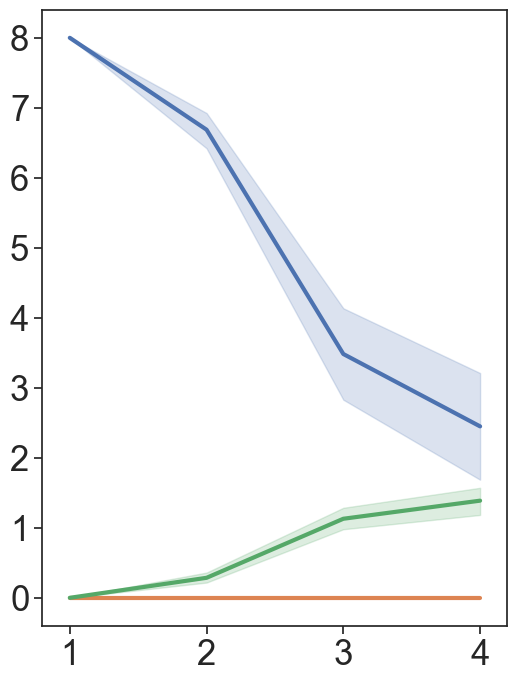

In [86]:
# df_model_avg = df_model.groupby(['ppt','alpha','beta','repetition']).mean().reset_index()

fig = plt.figure(figsize=(6,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 3})
#sns.lineplot(data=df_model_avg.query('modelType == "noDSL"'), x='repetition', y='intended_blocks',  linestyle = '--', color = 'black')
sns.lineplot(data=subset, x='repetition', y='intended_blocks',  palette=block_palette)
sns.lineplot(data=subset, x='repetition', y='intended_subtowers', palette=subtower_palette)
g = sns.lineplot(data=subset, x='repetition', y='intended_towers', palette=tower_palette)
g.legend().remove()
g.set(xlim=(0.8,4.2))
g.set(xticks=[1,2,3,4])
g.set(xticklabels=['1','2','3','4'])
g.set_yticklabels([str(int(y)) for y in g.get_yticks()], size = 25)
g.set_xticklabels([str(int(x)) for x in g.get_xticks()], size = 25)
g.set(ylabel='')
g.set(xlabel='')

In [87]:
fig.savefig('../results/plots/fig6B.pdf', transparent=False, bbox_inches='tight', pad_inches=0)